# コサインスケジューリング

Epoch 1/100, Loss: 0.4490
Epoch 11/100, Loss: 0.1768
Epoch 21/100, Loss: 0.1546
Epoch 31/100, Loss: 0.1482
Epoch 41/100, Loss: 0.1489
Epoch 51/100, Loss: 0.1409
Epoch 61/100, Loss: 0.1468
Epoch 71/100, Loss: 0.1377
Epoch 81/100, Loss: 0.1419
Epoch 91/100, Loss: 0.1334
Epoch 100/100, Loss: 0.1331


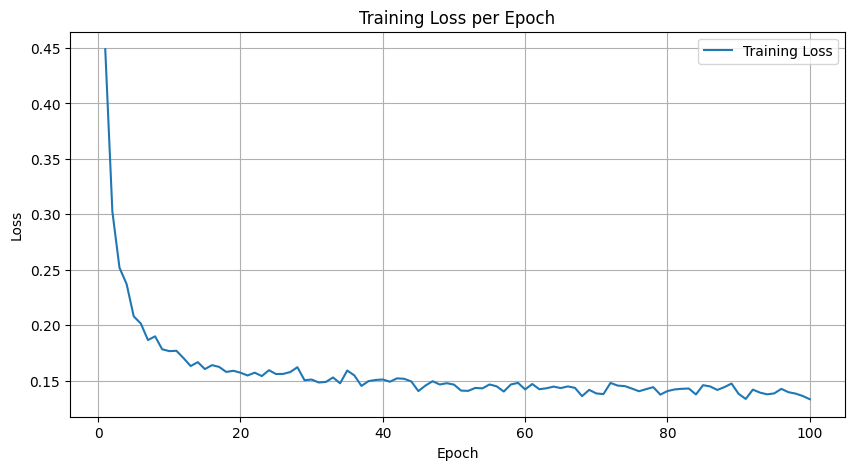

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

T,time_emb_dim,hidden_dim1 = 20, 32, 64 # OK
T,time_emb_dim,hidden_dim1 = 20, 32, 128 #OK
T,time_emb_dim,hidden_dim1 = 20, 64, 32 # NG
T,time_emb_dim,hidden_dim1 = 20, 64, 128 # OK
T,time_emb_dim,hidden_dim1 = 10, 64, 128 # OK


# 乱数シードの設定（再現性のため）
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# --- データのロードと前処理 ---
digits = load_digits()
# [-1, 1]に正規化し、画像サイズ(1,8,8)にリシェイプ
data = (digits.data / 8.0) - 1  
data = torch.tensor(data, dtype=torch.float32).view(-1, 1, 8, 8)
targets = torch.tensor(digits.target, dtype=torch.int64)
dataset = TensorDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# --- コサインスケーリングによるβスケジュール ---
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    return np.clip(betas, 0, 0.999)

betas = cosine_beta_schedule(T)
betas = torch.tensor(betas, dtype=torch.float32)

alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# --- GPUの設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# スケジュール関連のテンソルをGPUに移動
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)

# --- forward diffusion: x0 -> xt ---
def forward_diffusion_sample(x_0, t):
    """
    x_0: 元データ（形状: batch_size x 1 x 8 x 8）
    t: 拡散ステップ（各サンプルごとにランダムに選ぶ）
    戻り値: ノイズを加えたx_tと付加したノイズ
    """
    noise = torch.randn_like(x_0)
    # 係数を (batch, 1, 1, 1) にリシェイプして、画像全体に対してブロードキャスト可能にする
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# --- 時刻埋め込みの実装 ---
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super(TimeEmbedding, self).__init__()
        self.linear1 = nn.Linear(1, embed_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(embed_dim, embed_dim)
    def forward(self, t):
        t = t.unsqueeze(1).float()  # (batch, 1)に変換
        return self.linear2(self.relu(self.linear1(t)))

# --- CNNを用いた拡散モデル ---
class CNN_DiffusionModel(nn.Module):
    def __init__(self, input_channels, time_emb_dim, hidden_dim):
        super(CNN_DiffusionModel, self).__init__()
        self.time_embed = TimeEmbedding(time_emb_dim)
        # 時刻情報を画像サイズ(8x8)の特徴マップに変換
        self.fc_time = nn.Linear(time_emb_dim, 8*8)
        # 入力は画像1チャネル + 時刻特徴1チャネル = 2チャネル
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels + 1, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, input_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, t):
        # x: (batch, 1, 8, 8) を想定
        t_emb = self.time_embed(t)
        t_feat = self.fc_time(t_emb).view(-1, 1, 8, 8)
        x_input = torch.cat([x, t_feat], dim=1)  # チャネル数は2
        return self.conv(x_input)

# --- モデル、最適化手法の設定 ---
input_channels = data.shape[1]  # 1チャネル


model = CNN_DiffusionModel(input_channels, time_emb_dim, hidden_dim1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# --- 拡散モデルの学習 ---
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data, _ in dataloader:
        batch_data = batch_data.to(device)  # 形状: (batch, 1, 8, 8)
        batch_size = batch_data.size(0)
        t = torch.randint(0, T, (batch_size,), device=device)
        x_t, noise = forward_diffusion_sample(batch_data, t)
        noise_pred = model(x_t, t)
        loss = mse_loss(noise_pred, noise.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(dataloader.dataset)
    losses.append(epoch_loss)
    if epoch%10 ==0 or epoch==num_epochs-1:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# --- 学習ロスのプロット ---
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
# 学習後にモデルを保存する例
save_path = "cnn_diffusion_model.pth"
torch.save(model.state_dict(), save_path)
print(f"モデルを {save_path} に保存しました。")


モデルを cnn_diffusion_model.pth に保存しました。


In [4]:
# モデルの再定義（保存時と同じ構造・ハイパーパラメータであることが必要）


# モデルのインスタンスを作成してGPUに乗せる
loaded_model = CNN_DiffusionModel(input_channels, time_emb_dim, hidden_dim1).to(device)

# 保存したパラメータをロード
loaded_model.load_state_dict(torch.load("cnn_diffusion_model.pth"))
loaded_model.eval()  # 評価モードに切替

CNN_DiffusionModel(
  (time_embed): TimeEmbedding(
    (linear1): Linear(in_features=1, out_features=64, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc_time): Linear(in_features=64, out_features=64, bias=True)
  (conv): Sequential(
    (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

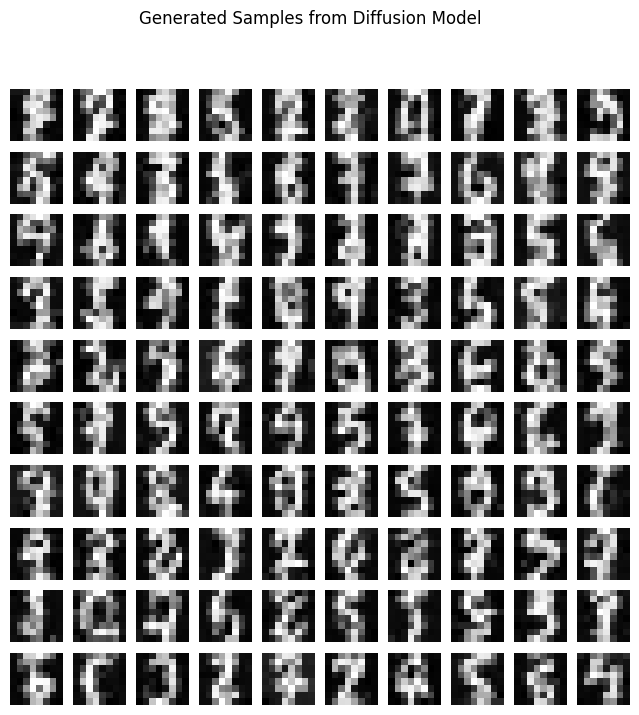

In [5]:
# --- 逆拡散過程（生成）の実装 ---
@torch.no_grad()
def sample_images(model, sample_size):
    model.eval()
    # 初期のxの形状を (sample_size, 1, 8, 8) に変更
    x = torch.randn(sample_size, input_channels, 8, 8).to(device)
    for t in reversed(range(T)):
        t_batch = torch.full((sample_size,), t, device=device, dtype=torch.long)
        epsilon_theta = model(x, t_batch)
        beta_t = betas[t].to(device)
        alpha_t = alphas[t].to(device)
        # ここではスカラーなのでそのままで問題ありません
        sqrt_recip_alpha_t = torch.sqrt(1.0 / alpha_t)
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        x = sqrt_recip_alpha_t * (x - (beta_t / sqrt_one_minus_alpha_cumprod_t) * epsilon_theta)
        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = x + sigma_t * noise
    return x

gen_image1, gen_image2 = 10, 10
# --- 生成結果の表示 ---
sampled_images = sample_images(model, sample_size=gen_image1*gen_image2)
sampled_images = sampled_images.cpu().numpy()

plt.figure(figsize=(8,8))
for i in range(gen_image1*gen_image2):
    plt.subplot(gen_image1,gen_image2 ,i+1)
    plt.imshow(sampled_images[i].reshape(8, 8), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Samples from Diffusion Model")
plt.show()


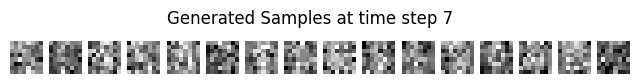

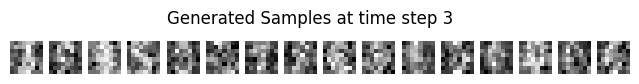

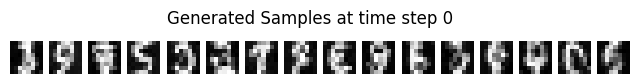

In [6]:
# --- 逆拡散過程（生成）の実装 ---  
@torch.no_grad()
def sample_images(model, sample_size, per_step=4):
    model.eval()
    # 初期のxの形状を (sample_size, 1, 8, 8) に変更
    x = torch.randn(sample_size, input_channels, 8, 8).to(device)
    # 中間結果を保存する辞書（キーはタイムステップ）
    intermediate_images = {}
    
    # 逆拡散過程（t = T-1 ... 0）
    for t in reversed(range(T)):
        t_batch = torch.full((sample_size,), t, device=device, dtype=torch.long)
        epsilon_theta = model(x, t_batch)
        beta_t = betas[t].to(device)
        alpha_t = alphas[t].to(device)
        sqrt_recip_alpha_t = torch.sqrt(1.0 / alpha_t)
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        x = sqrt_recip_alpha_t * (x - (beta_t / sqrt_one_minus_alpha_cumprod_t) * epsilon_theta)
        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = x + sigma_t * noise
        # 10タイムステップごと、またはt==0（最終ステップ）のときに中間結果を保存
        if ((t + 1) % per_step == 0) or (t == 0):
            intermediate_images[t] = x.clone()
    return intermediate_images

# --- 生成画像の取得 ---
gen_image1, gen_image2 = 1,16  # 表示する画像数のグリッド（例として5x5）
per_step= T/5
inter_images = sample_images(model, sample_size=gen_image1 * gen_image2)

# --- 各タイムステップごとに生成結果を表示 ---
for t in sorted(inter_images.keys(), reverse=True):
    imgs = inter_images[t].cpu().numpy()
    plt.figure(figsize=(8,1))
    plt.suptitle(f"Generated Samples at time step {t}")
    for i in range(gen_image1 * gen_image2):
        plt.subplot(gen_image1, gen_image2, i + 1)
        plt.imshow(imgs[i].reshape(8, 8), cmap="gray")
        plt.axis("off")
    plt.show()


# 線形スケジューリング

Epoch 1/100, Loss: 0.8617
Epoch 11/100, Loss: 0.4501
Epoch 21/100, Loss: 0.3979
Epoch 31/100, Loss: 0.3922
Epoch 41/100, Loss: 0.3919
Epoch 51/100, Loss: 0.3720
Epoch 61/100, Loss: 0.3729
Epoch 71/100, Loss: 0.3638
Epoch 81/100, Loss: 0.3628
Epoch 91/100, Loss: 0.3589
Epoch 100/100, Loss: 0.3482


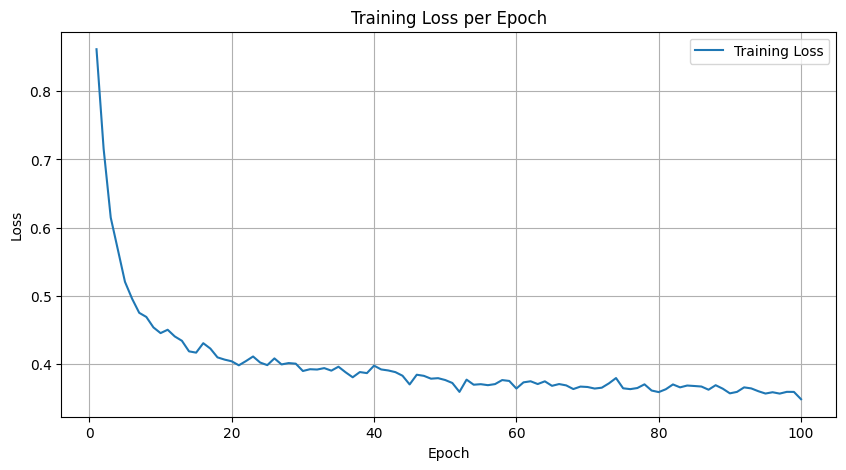

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

T, time_emb_dim,hidden_dim1  = 20, 32, 128  # 拡散ステップ数

# 乱数シードの設定（再現性のため）
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# --- データのロードと前処理 ---
digits = load_digits()
# [-1, 1]に正規化し、画像サイズ(1,8,8)にリシェイプ
data = (digits.data / 8.0) - 1  
data = torch.tensor(data, dtype=torch.float32).view(-1, 1, 8, 8)
targets = torch.tensor(digits.target, dtype=torch.int64)
dataset = TensorDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# --- 線形スケジュールによるβスケジュール ---
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """
    timesteps: 拡散ステップ数
    beta_start: 初期のβ値
    beta_end: 最終のβ値
    """
    return np.linspace(beta_start, beta_end, timesteps)

betas = linear_beta_schedule(T)
betas = torch.tensor(betas, dtype=torch.float32)

alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# --- GPUの設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)

# --- forward diffusion: x0 -> xt ---
def forward_diffusion_sample(x_0, t):
    """
    x_0: 元データ（形状: batch_size x 1 x 8 x 8）
    t: 拡散ステップ（各サンプルごとにランダムに選ぶ）
    戻り値: ノイズを加えたx_tと付加したノイズ
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# --- 時刻埋め込みの実装 ---
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super(TimeEmbedding, self).__init__()
        self.linear1 = nn.Linear(1, embed_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(embed_dim, embed_dim)
    def forward(self, t):
        t = t.unsqueeze(1).float()  # (batch, 1)に変換
        return self.linear2(self.relu(self.linear1(t)))

# --- CNNを用いた拡散モデル ---
class CNN_DiffusionModel(nn.Module):
    def __init__(self, input_channels, time_emb_dim, hidden_dim):
        super(CNN_DiffusionModel, self).__init__()
        self.time_embed = TimeEmbedding(time_emb_dim)
        # 時刻情報を画像サイズ(8x8)の特徴マップに変換
        self.fc_time = nn.Linear(time_emb_dim, 8*8)
        # 入力は画像1チャネル + 時刻特徴1チャネル = 2チャネル
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels + 1, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, input_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, t):
        # x: (batch, 1, 8, 8) を想定
        t_emb = self.time_embed(t)
        t_feat = self.fc_time(t_emb).view(-1, 1, 8, 8)
        x_input = torch.cat([x, t_feat], dim=1)  # チャネル数は2
        return self.conv(x_input)

# --- モデル、最適化手法の設定 ---
input_channels = data.shape[1]  # 1チャネル

model = CNN_DiffusionModel(input_channels, time_emb_dim, hidden_dim1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# --- 拡散モデルの学習 ---
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data, _ in dataloader:
        batch_data = batch_data.to(device)  # 形状: (batch, 1, 8, 8)
        batch_size = batch_data.size(0)
        t = torch.randint(0, T, (batch_size,), device=device)
        x_t, noise = forward_diffusion_sample(batch_data, t)
        noise_pred = model(x_t, t)
        loss = mse_loss(noise_pred, noise.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(dataloader.dataset)
    losses.append(epoch_loss)
    if epoch%10==0 or epoch==num_epochs-1:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# --- 学習ロスのプロット ---
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


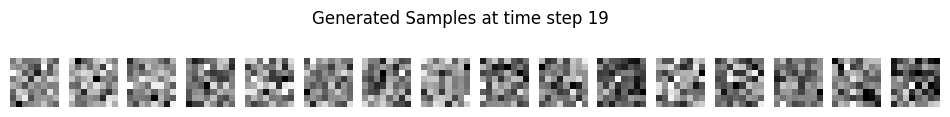

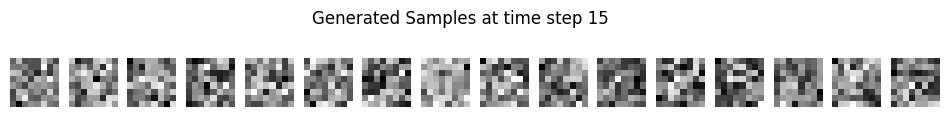

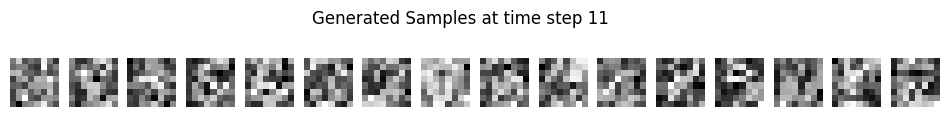

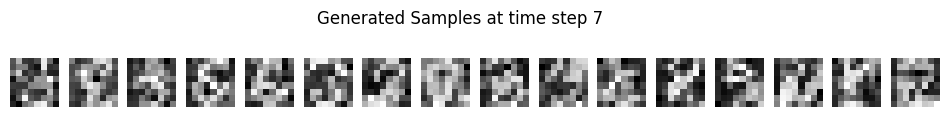

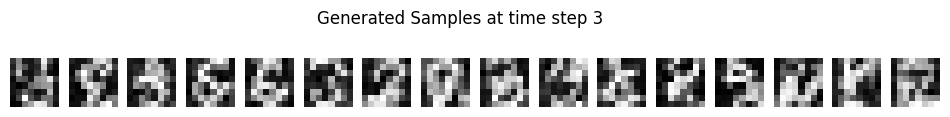

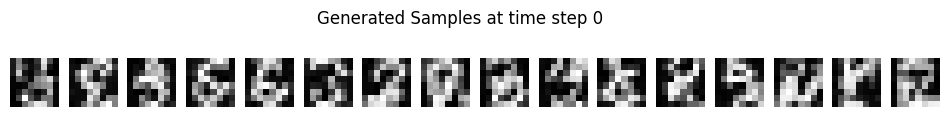

In [8]:
# --- 逆拡散過程（生成）の実装 ---  
@torch.no_grad()
def sample_images(model, sample_size, per_step=4):
    model.eval()
    # 初期のxの形状を (sample_size, 1, 8, 8) に変更
    x = torch.randn(sample_size, input_channels, 8, 8).to(device)
    # 中間結果を保存する辞書（キーはタイムステップ）
    intermediate_images = {}
    
    # 逆拡散過程（t = T-1 ... 0）
    for t in reversed(range(T)):
        t_batch = torch.full((sample_size,), t, device=device, dtype=torch.long)
        epsilon_theta = model(x, t_batch)
        beta_t = betas[t].to(device)
        alpha_t = alphas[t].to(device)
        sqrt_recip_alpha_t = torch.sqrt(1.0 / alpha_t)
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        x = sqrt_recip_alpha_t * (x - (beta_t / sqrt_one_minus_alpha_cumprod_t) * epsilon_theta)
        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = x + sigma_t * noise
        # 10タイムステップごと、またはt==0（最終ステップ）のときに中間結果を保存
        if ((t + 1) % per_step == 0) or (t == 0):
            intermediate_images[t] = x.clone()
    return intermediate_images

# --- 生成画像の取得 ---
gen_image1, gen_image2 = 1,16  # 表示する画像数のグリッド（例として5x5）
per_step= int(T/5)
inter_images = sample_images(model, sample_size=gen_image1 * gen_image2)

# --- 各タイムステップごとに生成結果を表示 ---
for t in sorted(inter_images.keys(), reverse=True):
    imgs = inter_images[t].cpu().numpy()
    plt.figure(figsize=(12,1.5))
    plt.suptitle(f"Generated Samples at time step {t}")
    for i in range(gen_image1 * gen_image2):
        plt.subplot(gen_image1, gen_image2, i + 1)
        plt.imshow(imgs[i].reshape(8, 8), cmap="gray")
        plt.axis("off")
    plt.show()


# adapter

Epoch 1/100, Loss: 0.4862
Epoch 11/100, Loss: 0.1872
Epoch 21/100, Loss: 0.1533
Epoch 31/100, Loss: 0.1508
Epoch 41/100, Loss: 0.1502
Epoch 51/100, Loss: 0.1358
Epoch 61/100, Loss: 0.1423
Epoch 71/100, Loss: 0.1299
Epoch 81/100, Loss: 0.1334
Epoch 91/100, Loss: 0.1300
Epoch 100/100, Loss: 0.1250


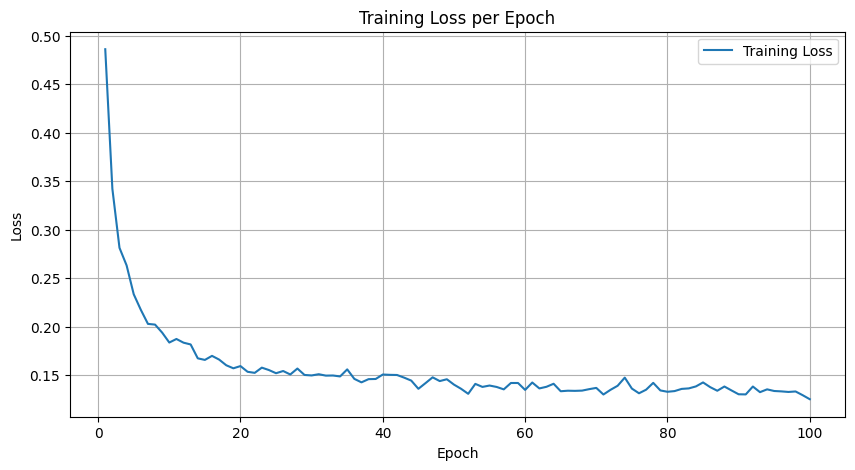

In [9]:


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

# --- ハイパーパラメータ ---
# T: 拡散ステップ数, time_emb_dim: 時刻埋め込み次元, hidden_dim: CNN内部のチャネル数
T, time_emb_dim, hidden_dim = 20, 32, 128

# 乱数シードの設定（再現性のため）
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# --- データのロードと前処理 ---
digits = load_digits()
# [-1, 1]に正規化し、画像サイズ(1,8,8)にリシェイプ
data = (digits.data / 8.0) - 1  
data = torch.tensor(data, dtype=torch.float32).view(-1, 1, 8, 8)
targets = torch.tensor(digits.target, dtype=torch.int64)
dataset = TensorDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# --- コサインスケーリングによるβスケジュール ---
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    return np.clip(betas, 0, 0.999)

betas = cosine_beta_schedule(T)
betas = torch.tensor(betas, dtype=torch.float32)

alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# --- GPUの設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)

# --- forward diffusion: x0 -> xt ---
def forward_diffusion_sample(x_0, t):
    """
    x_0: 元データ (batch, 1, 8, 8)
    t: 拡散ステップ (各サンプルごとにランダムに選ぶ)
    戻り値: ノイズを加えた x_t と付加したノイズ
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# --- 時刻埋め込み ---
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super(TimeEmbedding, self).__init__()
        self.linear1 = nn.Linear(1, embed_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(embed_dim, embed_dim)
    def forward(self, t):
        t = t.unsqueeze(1).float()  # (batch, 1)に変換
        return self.linear2(self.relu(self.linear1(t)))

# --- ラベルアダプター ---
class LabelAdapter(nn.Module):
    def __init__(self, num_classes, embed_dim, spatial_dim):
        super(LabelAdapter, self).__init__()
        self.embedding = nn.Embedding(num_classes, embed_dim)
        self.fc = nn.Linear(embed_dim, spatial_dim * spatial_dim)
    def forward(self, labels):
        # labels: (batch,) の整数テンソル
        label_emb = self.embedding(labels)
        label_feat = self.fc(label_emb)
        return label_feat.view(-1, 1, 8, 8)  # (batch, 1, 8, 8)

# --- 条件付き拡散モデル ---
class ConditionalCNN_DiffusionModel(nn.Module):
    def __init__(self, input_channels, time_emb_dim, hidden_dim, num_classes, label_emb_dim):
        super(ConditionalCNN_DiffusionModel, self).__init__()
        self.time_embed = TimeEmbedding(time_emb_dim)
        self.fc_time = nn.Linear(time_emb_dim, 8 * 8)
        self.label_adapter = LabelAdapter(num_classes, label_emb_dim, spatial_dim=8)
        # 入力チャネル: 画像 (1) + 時刻特徴 (1) + ラベル特徴 (1) = 3チャネル
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels + 2, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, input_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, t, labels):
        # 時刻埋め込み処理
        t_emb = self.time_embed(t)
        t_feat = self.fc_time(t_emb).view(-1, 1, 8, 8)
        # ラベルアダプターでラベルを特徴マップに変換
        label_feat = self.label_adapter(labels)
        # x: (batch, 1, 8, 8)
        # 入力として x, 時刻特徴、ラベル特徴をチャネル方向で連結（1+1+1=3チャネル）
        x_input = torch.cat([x, t_feat, label_feat], dim=1)
        return self.conv(x_input)

# --- モデル、最適化手法の設定 ---
num_classes = 10
label_emb_dim = 32  # ラベル埋め込みの次元（任意）
input_channels = data.shape[1]  # 1チャネル
model = ConditionalCNN_DiffusionModel(input_channels, time_emb_dim, hidden_dim, num_classes, label_emb_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# --- 拡散モデルの学習 ---
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data, batch_labels in dataloader:
        batch_data = batch_data.to(device)  # (batch, 1, 8, 8)
        batch_labels = batch_labels.to(device)
        batch_size = batch_data.size(0)
        t = torch.randint(0, T, (batch_size,), device=device)
        x_t, noise = forward_diffusion_sample(batch_data, t)
        # ラベル情報もモデルに渡す
        noise_pred = model(x_t, t, batch_labels)
        loss = mse_loss(noise_pred, noise.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(dataloader.dataset)
    losses.append(epoch_loss)
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# --- 学習ロスのプロット ---
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()



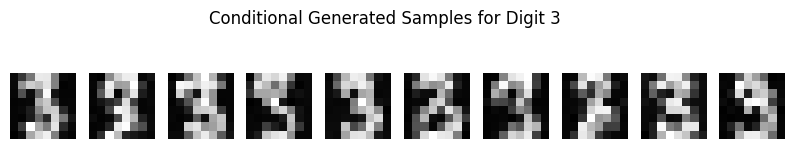

In [10]:

@torch.no_grad()
def p_sample(model, x, t, labels):
    """
    1ステップの逆拡散を行う関数（DDPMの更新式を使用）
    x: 現在の画像 (batch, 1, 8, 8)
    t: 現在の時刻（全サンプル同じ値のテンソル）
    labels: (batch,) 条件ラベル
    """
    # モデルからノイズ予測
    noise_pred = model(x, t, labels)
    
    # 現在のステップ t の各種係数（形状を (batch, 1, 1, 1) に整形）
    beta_t = betas[t].view(-1, 1, 1, 1)
    alpha_t = alphas[t].view(-1, 1, 1, 1)
    alpha_cumprod_t = alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alpha_cumprod_t)
    
    # DDPMの更新式に基づく平均計算
    mean = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / sqrt_one_minus_alpha_cumprod_t) * noise_pred)
    
    # t==0のときはノイズ項を足さない（最終ステップ）
    noise = torch.randn_like(x) if t[0].item() > 0 else 0
    sigma = torch.sqrt(beta_t)
    
    return mean + sigma * noise



@torch.no_grad()
def sample_image(model, label, shape, T):
    """
    条件付きで画像を生成する関数
    label: (batch,) 条件ラベル。すべて同じラベルであれば、そのラベルの画像が生成される。
    shape: 生成する画像の形状 (batch, 1, 8, 8)
    T: 拡散ステップ数
    """
    model.eval()
    # 初期は純粋なノイズから開始
    x = torch.randn(shape, device=device)
    # 逆拡散プロセス: t = T-1 から 0 へ
    for t_step in reversed(range(T)):
        t_tensor = torch.full((shape[0],), t_step, device=device, dtype=torch.long)
        x = p_sample(model, x, t_tensor, label)
    return x



# --- 条件付きサンプル生成の例 ---
# 例として、バッチ内すべてのサンプルをラベル「3」として生成する
n_samples = 10
sample_label = torch.full((n_samples,), 3, dtype=torch.long, device=device)
sampled_images = sample_image(model, sample_label, (n_samples, 1, 8, 8), T)

plt.figure(figsize=(10, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(sampled_images[i].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.suptitle('Conditional Generated Samples for Digit 3')
plt.show()

In [11]:
sample_label

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')

# 追加学習

=== Unconditional Pre-training ===
Epoch 1/100, Loss: 0.4785
Epoch 11/100, Loss: 0.2086
Epoch 21/100, Loss: 0.1761
Epoch 31/100, Loss: 0.1732
Epoch 41/100, Loss: 0.1743
Epoch 51/100, Loss: 0.1607
Epoch 61/100, Loss: 0.1644
Epoch 71/100, Loss: 0.1504
Epoch 81/100, Loss: 0.1570
Epoch 91/100, Loss: 0.1517
Epoch 100/100, Loss: 0.1496
=== Conditional Fine-tuning (Partial Freezing) ===
Conditional Epoch 1/50, Loss: 1.0336
Conditional Epoch 11/50, Loss: 1.0281
Conditional Epoch 21/50, Loss: 1.0254
Conditional Epoch 31/50, Loss: 1.0159
Conditional Epoch 41/50, Loss: 1.0229
Conditional Epoch 50/50, Loss: 1.0233


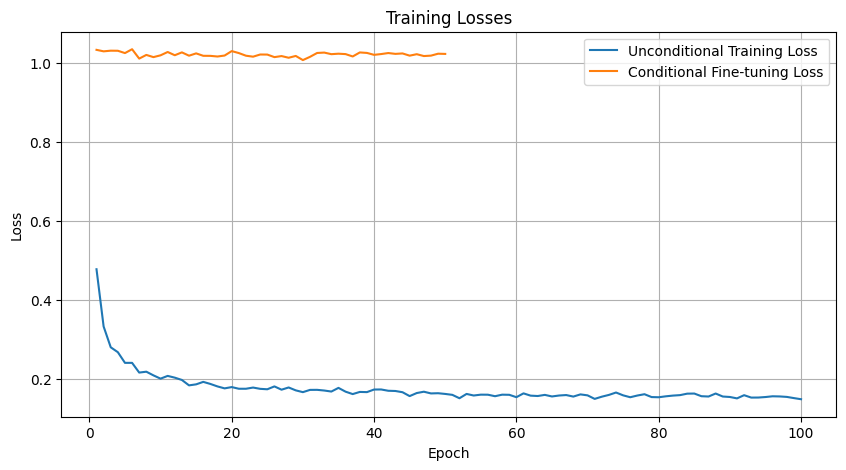

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random

# ============================
#  ハイパーパラメータ等の設定
# ============================
T, time_emb_dim, hidden_dim = 20, 32, 128
num_epochs_uncond = 100   # 条件なし事前学習のエポック数
num_epochs_cond   = 50    # 追加学習（条件付きファインチューニング）のエポック数
num_classes = 10
label_emb_dim = 32

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# =====================
#  データのロードと前処理
# =====================
digits = load_digits()
data = (digits.data / 8.0) - 1  # [-1,1]に正規化
data = torch.tensor(data, dtype=torch.float32).view(-1, 1, 8, 8)
targets = torch.tensor(digits.target, dtype=torch.int64)
dataset = TensorDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# =====================
#  βスケジュールの定義
# =====================
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    return np.clip(betas, 0, 0.999)

betas = cosine_beta_schedule(T)
betas = torch.tensor(betas, dtype=torch.float32)

alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)

# =====================
#  forward diffusion
# =====================
def forward_diffusion_sample(x_0, t):
    """
    x_0: 元画像 (batch, 1, 8, 8)
    t: 拡散ステップ（各サンプルごとにランダム）
    戻り値: ノイズを加えた x_t と加えたノイズ
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

# =====================
#  時刻埋め込みモジュール
# =====================
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super(TimeEmbedding, self).__init__()
        self.linear1 = nn.Linear(1, embed_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(embed_dim, embed_dim)
    def forward(self, t):
        t = t.unsqueeze(1).float()  # (batch, 1)
        return self.linear2(self.relu(self.linear1(t)))

# =====================
#  条件なしCNN拡散モデル
# =====================
class CNN_DiffusionModel(nn.Module):
    def __init__(self, input_channels, time_emb_dim, hidden_dim):
        super(CNN_DiffusionModel, self).__init__()
        self.time_embed = TimeEmbedding(time_emb_dim)
        self.fc_time = nn.Linear(time_emb_dim, 8 * 8)
        # 画像 (1チャネル) と時刻特徴 (1チャネル) を連結 → 2チャネル
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels + 1, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, input_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, t):
        t_emb = self.time_embed(t)
        t_feat = self.fc_time(t_emb).view(-1, 1, 8, 8)
        x_input = torch.cat([x, t_feat], dim=1)
        return self.conv(x_input)

# =====================
#  ラベルアダプター（条件付き部分）
# =====================
class LabelAdapter(nn.Module):
    def __init__(self, num_classes, embed_dim, spatial_dim):
        super(LabelAdapter, self).__init__()
        self.embedding = nn.Embedding(num_classes, embed_dim)
        self.fc = nn.Linear(embed_dim, spatial_dim * spatial_dim)
    def forward(self, labels):
        label_emb = self.embedding(labels)
        label_feat = self.fc(label_emb)
        return label_feat.view(-1, 1, 8, 8)

# =====================
#  条件付きCNN拡散モデル
# =====================
class ConditionalCNN_DiffusionModel(nn.Module):
    def __init__(self, input_channels, time_emb_dim, hidden_dim, num_classes, label_emb_dim):
        super(ConditionalCNN_DiffusionModel, self).__init__()
        self.time_embed = TimeEmbedding(time_emb_dim)
        self.fc_time = nn.Linear(time_emb_dim, 8 * 8)
        self.label_adapter = LabelAdapter(num_classes, label_emb_dim, spatial_dim=8)
        # 画像 (1チャネル) + 時刻特徴 (1チャネル) + ラベル特徴 (1チャネル) → 3チャネル
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels + 2, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, input_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, t, labels):
        t_emb = self.time_embed(t)
        t_feat = self.fc_time(t_emb).view(-1, 1, 8, 8)
        label_feat = self.label_adapter(labels)
        x_input = torch.cat([x, t_feat, label_feat], dim=1)
        return self.conv(x_input)

mse_loss = nn.MSELoss()

# ====================================================
# １．条件なし事前学習（Unconditional Pre-training）
# ====================================================
print("=== Unconditional Pre-training ===")
uncond_model = CNN_DiffusionModel(input_channels=1, time_emb_dim=time_emb_dim, hidden_dim=hidden_dim).to(device)
optimizer_uncond = optim.Adam(uncond_model.parameters(), lr=0.001)
losses_uncond = []

for epoch in range(num_epochs_uncond):
    uncond_model.train()
    epoch_loss = 0
    for batch_data, _ in dataloader:
        batch_data = batch_data.to(device)
        batch_size = batch_data.size(0)
        t = torch.randint(0, T, (batch_size,), device=device)
        x_t, noise = forward_diffusion_sample(batch_data, t)
        noise_pred = uncond_model(x_t, t)
        loss = mse_loss(noise_pred, noise.to(device))
        optimizer_uncond.zero_grad()
        loss.backward()
        optimizer_uncond.step()
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(dataloader.dataset)
    losses_uncond.append(epoch_loss)
    if epoch % 10 == 0 or epoch == num_epochs_uncond - 1:
        print(f"Epoch {epoch+1}/{num_epochs_uncond}, Loss: {epoch_loss:.4f}")

# ====================================================
# ２．ラベルアダプターの導入と条件付きモデルへの移行
# ====================================================
# 新たに条件付きモデルを構築し、事前学習済みuncond_modelの重みをコピー
cond_model = ConditionalCNN_DiffusionModel(input_channels=1, time_emb_dim=time_emb_dim, 
                                           hidden_dim=hidden_dim, num_classes=num_classes, 
                                           label_emb_dim=label_emb_dim).to(device)

# --- 時刻埋め込みとfc_timeの重みをコピー ---
cond_model.time_embed.load_state_dict(uncond_model.time_embed.state_dict())
cond_model.fc_time.load_state_dict(uncond_model.fc_time.state_dict())

# --- CNN部の重みコピー ---
# 最初の畳み込み層は、unconditionalモデルは入力チャネル2、conditionalは3チャンネルなので、
# unconditionalの重みを最初の2チャネルにコピー
with torch.no_grad():
    uncond_conv0 = uncond_model.conv[0]
    cond_conv0 = cond_model.conv[0]
    cond_conv0.weight[:, :2, :, :] = uncond_conv0.weight
    cond_conv0.bias.copy_(uncond_conv0.bias)
# 以降の層は形状が同じなのでそのままコピー
cond_model.conv[1].load_state_dict(uncond_model.conv[1].state_dict())
cond_model.conv[2].load_state_dict(uncond_model.conv[2].state_dict())

# ====================================================
# ３．部分的な凍結による追加学習（Conditional Fine-tuning）
# ====================================================
# unconditional部分（time_embed, fc_time, conv）は凍結し、ラベルアダプターのみを学習
for param in cond_model.time_embed.parameters():
    param.requires_grad = False
for param in cond_model.fc_time.parameters():
    param.requires_grad = False
for param in cond_model.conv.parameters():
    param.requires_grad = False
# ここでは、label_adapterのパラメータのみを学習対象とする
for param in cond_model.label_adapter.parameters():
    param.requires_grad = True

optimizer_cond = optim.Adam(cond_model.label_adapter.parameters(), lr=0.001)
losses_cond = []

print("=== Conditional Fine-tuning (Partial Freezing) ===")
for epoch in range(num_epochs_cond):
    cond_model.train()
    epoch_loss = 0
    for batch_data, batch_labels in dataloader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_size = batch_data.size(0)
        t = torch.randint(0, T, (batch_size,), device=device)
        x_t, noise = forward_diffusion_sample(batch_data, t)
        noise_pred = cond_model(x_t, t, batch_labels)
        loss = mse_loss(noise_pred, noise.to(device))
        optimizer_cond.zero_grad()
        loss.backward()
        optimizer_cond.step()
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(dataloader.dataset)
    losses_cond.append(epoch_loss)
    if epoch % 10 == 0 or epoch == num_epochs_cond - 1:
        print(f"Conditional Epoch {epoch+1}/{num_epochs_cond}, Loss: {epoch_loss:.4f}")

# ====================================================
#  結果のプロット
# ====================================================
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs_uncond+1), losses_uncond, label="Unconditional Training Loss")
plt.plot(range(1, num_epochs_cond+1), losses_cond, label="Conditional Fine-tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.show()


=== Conditional Fine-tuning with Convergence Monitoring and LR Scheduler ===
Epoch 1/50, Conditional Loss: 1.018289
Epoch 2/50, Conditional Loss: 1.022651
Epoch 3/50, Conditional Loss: 1.024681
Epoch 4/50, Conditional Loss: 1.027998
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch 5/50, Conditional Loss: 1.033544
Epoch 6/50, Conditional Loss: 1.018694
No improvement observed for several epochs. Early stopping triggered.


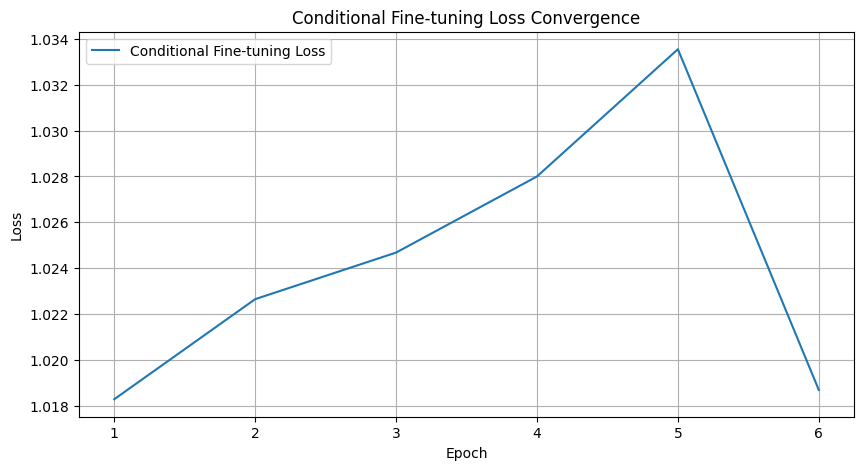

In [13]:
# 変更

import torch.optim.lr_scheduler as lr_scheduler

# LRスケジューラ（損失が改善しない場合に学習率を下げる）
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_cond, mode='min', factor=0.5, patience=2, verbose=True)

# 早期終了のためのパラメータ設定
patience = 5      # 改善が見られないエポック数の許容値
min_delta = 1e-4  # 改善とみなす損失の最小変化量
patience_counter = 0
best_loss = float('inf')
losses_cond = []

print("=== Conditional Fine-tuning with Convergence Monitoring and LR Scheduler ===")
for epoch in range(num_epochs_cond):
    cond_model.train()
    epoch_loss = 0.0
    for batch_data, batch_labels in dataloader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_size = batch_data.size(0)
        t = torch.randint(0, T, (batch_size,), device=device)
        x_t, noise = forward_diffusion_sample(batch_data, t)
        noise_pred = cond_model(x_t, t, batch_labels)
        loss = mse_loss(noise_pred, noise.to(device))
        optimizer_cond.zero_grad()
        loss.backward()
        optimizer_cond.step()
        epoch_loss += loss.item() * batch_size

    epoch_loss /= len(dataloader.dataset)
    losses_cond.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs_cond}, Conditional Loss: {epoch_loss:.6f}")
    
    # LRスケジューラに損失を渡して学習率を調整
    scheduler.step(epoch_loss)
    
    # 早期終了の判定
    if best_loss - epoch_loss > min_delta:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("No improvement observed for several epochs. Early stopping triggered.")
            break

# 損失推移のプロット
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses_cond)+1), losses_cond, label="Conditional Fine-tuning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Conditional Fine-tuning Loss Convergence")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import random

# ※ ここでは既存のモデル定義（TimeEmbedding, LabelAdapter, CNN_DiffusionModel, ConditionalCNN_DiffusionModel等）
# およびデータ、βスケジュール、forward_diffusion_sample等は前提としてインポート済みまたは定義済みとします。

# ハイパーパラメータ
T = 20
num_classes = 10
time_emb_dim = 32
hidden_dim = 128
label_emb_dim = 32

num_epochs_phase1 = 50  # フェーズ1: ラベルアダプターのみのファインチューニング
num_epochs_phase2 = 50  # フェーズ2: 部分的な凍結解除＋全体再学習（低LR）

# --- 前提: cond_model は既に unconditional部分の重みをコピーした ConditionalCNN_DiffusionModel ---
# cond_model, dataloader, device, mse_loss, forward_diffusion_sample, alphas_cumprod, T などが定義されているものとします。

########################################
# Phase 1: ラベルアダプターのみの学習
########################################

# すでに cond_model の uncond 部分は freeze されている前提
for param in cond_model.time_embed.parameters():
    param.requires_grad = False
for param in cond_model.fc_time.parameters():
    param.requires_grad = False
for param in cond_model.conv.parameters():
    param.requires_grad = False
# label_adapter のみ学習対象
for param in cond_model.label_adapter.parameters():
    param.requires_grad = True

optimizer_phase1 = optim.Adam(cond_model.label_adapter.parameters(), lr=0.001)
scheduler_phase1 = ReduceLROnPlateau(optimizer_phase1, mode='min', factor=0.5, patience=3, verbose=True)

losses_phase1 = []
best_loss_phase1 = float('inf')

print("=== Phase 1: Fine-tuning Label Adapter Only ===")
for epoch in range(num_epochs_phase1):
    cond_model.train()
    epoch_loss = 0.0
    for batch_data, batch_labels in dataloader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_size = batch_data.size(0)
        t = torch.randint(0, T, (batch_size,), device=device)
        x_t, noise = forward_diffusion_sample(batch_data, t)
        noise_pred = cond_model(x_t, t, batch_labels)
        loss = mse_loss(noise_pred, noise.to(device))
        optimizer_phase1.zero_grad()
        loss.backward()
        optimizer_phase1.step()
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(dataloader.dataset)
    losses_phase1.append(epoch_loss)
    scheduler_phase1.step(epoch_loss)
    print(f"[Phase1] Epoch {epoch+1}/{num_epochs_phase1}, Loss: {epoch_loss:.6f}")
    if epoch_loss < best_loss_phase1:
        best_loss_phase1 = epoch_loss

# もしフェーズ1終了時の損失が依然として高い（例: 0.9以上）場合は、フェーズ2に進む
print(f"Phase1 finished, best loss: {best_loss_phase1:.6f}")

########################################
# Phase 2: Unfreeze 一部（fc_time と conv）も再調整
########################################

# もしフェーズ1の損失が改善されなかった場合、fc_time と conv 層も再学習可能にする
if best_loss_phase1 > 0.5:  # ここは目安です。状況に応じて調整してください。
    print("Phase1 loss did not decrease sufficiently. Starting Phase2 fine-tuning.")
    for param in cond_model.fc_time.parameters():
        param.requires_grad = True
    for param in cond_model.conv.parameters():
        param.requires_grad = True
    # label_adapter も引き続き学習対象
    # 異なる学習率でパラメータグループを設定（unconditional部分は低いLR）
    optimizer_phase2 = optim.Adam([
        {"params": cond_model.label_adapter.parameters(), "lr": 0.001},
        {"params": cond_model.fc_time.parameters(), "lr": 1e-4},
        {"params": cond_model.conv.parameters(), "lr": 1e-4},
        # 時刻埋め込みは通常はそのまま凍結していますが、必要なら解除も検討可能
    ])
    scheduler_phase2 = ReduceLROnPlateau(optimizer_phase2, mode='min', factor=0.5, patience=3, verbose=True)
    losses_phase2 = []
    best_loss_phase2 = float('inf')
    for epoch in range(num_epochs_phase2):
        cond_model.train()
        epoch_loss = 0.0
        for batch_data, batch_labels in dataloader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            batch_size = batch_data.size(0)
            t = torch.randint(0, T, (batch_size,), device=device)
            x_t, noise = forward_diffusion_sample(batch_data, t)
            noise_pred = cond_model(x_t, t, batch_labels)
            loss = mse_loss(noise_pred, noise.to(device))
            optimizer_phase2.zero_grad()
            loss.backward()
            optimizer_phase2.step()
            epoch_loss += loss.item() * batch_size
        epoch_loss /= len(dataloader.dataset)
        losses_phase2.append(epoch_loss)
        scheduler_phase2.step(epoch_loss)
        print(f"[Phase2] Epoch {epoch+1}/{num_epochs_phase2}, Loss: {epoch_loss:.6f}")
        if epoch_loss < best_loss_phase2:
            best_loss_phase2 = epoch_loss
    print(f"Phase2 finished, best loss: {best_loss_phase2:.6f}")
else:
    print("Phase1 fine-tuning achieved sufficient loss reduction; skipping Phase2.")

# ※ ここで、最終的な conditional loss がどの程度になったかを確認してください。


=== Phase 1: Fine-tuning Label Adapter Only ===
[Phase1] Epoch 1/50, Loss: 1.020232
[Phase1] Epoch 2/50, Loss: 1.018410
[Phase1] Epoch 3/50, Loss: 1.019005
[Phase1] Epoch 4/50, Loss: 1.022604
[Phase1] Epoch 5/50, Loss: 1.026595
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
[Phase1] Epoch 6/50, Loss: 1.019797
[Phase1] Epoch 7/50, Loss: 1.025010
[Phase1] Epoch 8/50, Loss: 1.022116
[Phase1] Epoch 9/50, Loss: 1.024346
Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
[Phase1] Epoch 10/50, Loss: 1.027083
[Phase1] Epoch 11/50, Loss: 1.021652
[Phase1] Epoch 12/50, Loss: 1.026085
[Phase1] Epoch 13/50, Loss: 1.020118
Epoch 00014: reducing learning rate of group 0 to 1.2500e-04.
[Phase1] Epoch 14/50, Loss: 1.020990
[Phase1] Epoch 15/50, Loss: 1.021225
[Phase1] Epoch 16/50, Loss: 1.024051
[Phase1] Epoch 17/50, Loss: 1.023977
Epoch 00018: reducing learning rate of group 0 to 6.2500e-05.
[Phase1] Epoch 18/50, Loss: 1.022963
[Phase1] Epoch 19/50, Loss: 1.025123
[Phase1] E

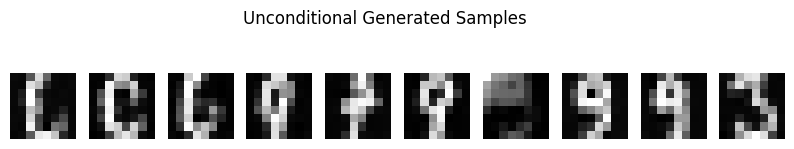

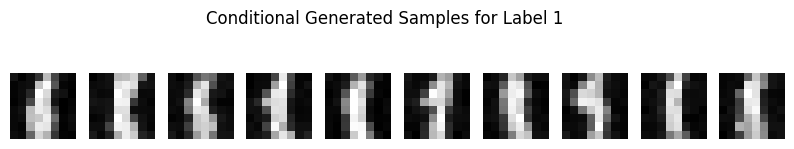

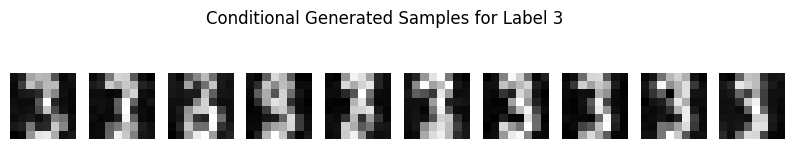

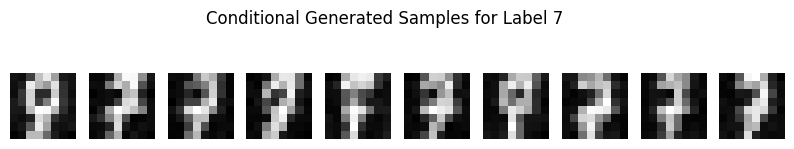

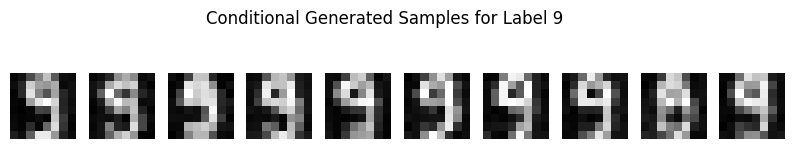

In [15]:
@torch.no_grad()
def sample_image_uncond(model, shape, T):
    """
    Unconditionalなモデルを用いて画像を生成する関数
    Args:
      model: CNN_DiffusionModel（条件なし）
      shape: 生成する画像の形状 (batch, 1, 8, 8)
      T: 拡散ステップ数
    Returns:
      生成された画像テンソル
    """
    model.eval()
    x = torch.randn(shape, device=device)  # 初期は純粋なノイズ
    for t in reversed(range(T)):
        # 現在の拡散ステップ t を示すテンソル（バッチサイズ分）
        t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
        # モデルによるノイズ予測
        pred_noise = model(x, t_tensor)
        # 現在の係数
        alpha_cumprod_t = alphas_cumprod[t].view(1, 1, 1, 1)
        sqrt_recip = 1.0 / torch.sqrt(alpha_cumprod_t)
        sqrt_one_minus = torch.sqrt(1 - alpha_cumprod_t)
        # 推定された x0 を計算
        x0_pred = (x - sqrt_one_minus * pred_noise) * sqrt_recip
        # t > 0 の場合はノイズを加える
        noise = torch.randn_like(x) if t > 0 else 0
        # t-1 に対応する係数（t==0の場合は1.0）
        alpha_cumprod_prev = alphas_cumprod[t-1].view(1, 1, 1, 1) if t > 0 else torch.tensor(1.0, device=device)
        # 逆拡散更新式
        x = torch.sqrt(alpha_cumprod_prev) * x0_pred + torch.sqrt(1 - alpha_cumprod_prev) * noise
    return x

@torch.no_grad()
def sample_image_cond(model, label, shape, T):
    """
    Conditionalなモデルを用いて画像を生成する関数
    Args:
      model: ConditionalCNN_DiffusionModel（条件付き）
      label: (batch,) 生成したい条件ラベル（例: 3）
      shape: 生成する画像の形状 (batch, 1, 8, 8)
      T: 拡散ステップ数
    Returns:
      生成された画像テンソル
    """
    model.eval()
    x = torch.randn(shape, device=device)  # 初期は純粋なノイズ
    for t in reversed(range(T)):
        t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_tensor, label)
        alpha_cumprod_t = alphas_cumprod[t].view(1, 1, 1, 1)
        sqrt_recip = 1.0 / torch.sqrt(alpha_cumprod_t)
        sqrt_one_minus = torch.sqrt(1 - alpha_cumprod_t)
        x0_pred = (x - sqrt_one_minus * pred_noise) * sqrt_recip
        noise = torch.randn_like(x) if t > 0 else 0
        alpha_cumprod_prev = alphas_cumprod[t-1].view(1, 1, 1, 1) if t > 0 else torch.tensor(1.0, device=device)
        x = torch.sqrt(alpha_cumprod_prev) * x0_pred + torch.sqrt(1 - alpha_cumprod_prev) * noise
    return x

# ---------- Unconditional での画像生成 ----------
n_samples = 10
# unconditionalモデル(uncond_model)は条件なしのCNN_DiffusionModelで学習済み
uncond_generated = sample_image_uncond(uncond_model, (n_samples, 1, 8, 8), T)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(uncond_generated[i].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.suptitle('Unconditional Generated Samples')
plt.show()


# ---------- Conditional でラベル1に対する画像生成 ----------
# 条件付きモデル(cond_model)は先ほどラベルアダプター付きで追加学習済み
target_label = 1
sample_label = torch.full((n_samples,), target_label, dtype=torch.long, device=device)
cond_generated = sample_image_cond(cond_model, sample_label, (n_samples, 1, 8, 8), T)

plt.figure(figsize=(10, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(cond_generated[i].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.suptitle(f'Conditional Generated Samples for Label {target_label}')
plt.show()


# ---------- Conditional でラベル3に対する画像生成 ----------
# 条件付きモデル(cond_model)は先ほどラベルアダプター付きで追加学習済み
target_label = 3
sample_label = torch.full((n_samples,), 3, dtype=torch.long, device=device)
cond_generated = sample_image_cond(cond_model, sample_label, (n_samples, 1, 8, 8), T)

plt.figure(figsize=(10, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(cond_generated[i].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.suptitle(f'Conditional Generated Samples for Label {target_label}')
plt.show()

# ---------- Conditional でラベル7に対する画像生成 ----------
# 条件付きモデル(cond_model)は先ほどラベルアダプター付きで追加学習済み
target_label = 7
sample_label = torch.full((n_samples,), target_label, dtype=torch.long, device=device)
cond_generated = sample_image_cond(cond_model, sample_label, (n_samples, 1, 8, 8), T)

plt.figure(figsize=(10, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(cond_generated[i].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.suptitle(f'Conditional Generated Samples for Label {target_label}')
plt.show()

# ---------- Conditional でラベル9に対する画像生成 ----------
# 条件付きモデル(cond_model)は先ほどラベルアダプター付きで追加学習済み
target_label = 9
sample_label = torch.full((n_samples,), target_label, dtype=torch.long, device=device)
cond_generated = sample_image_cond(cond_model, sample_label, (n_samples, 1, 8, 8), T)

plt.figure(figsize=(10, 2))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(cond_generated[i].cpu().squeeze(0), cmap='gray')
    plt.axis('off')
plt.suptitle(f'Conditional Generated Samples for Label {target_label}')
plt.show()